In [1]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000=[]
angulo_real_5000_5000= []
errores_relativos_5000_5000=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        if v_wind[1:2]==[0.,0.]
                phis=[deepcopy(phi_i)]
                if l==1
                    thetas= range(theta_i, theta_i+10/(2^(l-1)), 50);
                else
                     thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
                end
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
                thetas= range(theta_i, theta_i+10/(2^(l-1)), 50); #Distancia angular de 10 grados como cota superior basado en datos propios
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
                thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
 47.110357 seconds (562.53 M allocations: 30.981 GiB, 12.50% gc time, 7.90% compilation time)


In [2]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,1.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_1=[]
angulo_real_5000_5000_1= []
errores_relativos_5000_5000_1=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_1,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        if v_wind[1:2]==[0.,0.]
                phis=[deepcopy(phi_i)]
                if l==1
                    thetas= range(theta_i, theta_i+10/(2^(l-1)), 50);
                else
                     thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
                end
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
                thetas= range(theta_i, theta_i+10/(2^(l-1)), 50); #Distancia angular de 10 grados como cota superior basado en datos propios
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
                thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_1,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_1,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
 40.721032 seconds (556.64 M allocations: 30.605 GiB, 13.58% gc time, 0.17% compilation time: 67% of which was recompilation)


In [3]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,5.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_5=[]
angulo_real_5000_5000_5= []
errores_relativos_5000_5000_5=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_5,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
                if detener==1
            break
        end     
        if v_wind[1:2]==[0.,0.]
                phis=[deepcopy(phi_i)]
                if l==1
                    thetas= range(theta_i, theta_i+10/(2^(l-1)), 50);
                else
                     thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
                end
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
                thetas= range(theta_i, theta_i+10/(2^(l-1)), 50); #Distancia angular de 10 grados como cota superior basado en datos propios
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
                thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_5,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_5,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
 42.298207 seconds (551.84 M allocations: 30.345 GiB, 13.40% gc time, 0.17% compilation time: 63% of which was recompilation)


In [4]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,10.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_10=[]
angulo_real_5000_5000_10= []
errores_relativos_5000_5000_10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
       if detener==1
            break
        end     
        if v_wind[1:2]==[0.,0.]
                phis=[deepcopy(phi_i)]
                if l==1
                    thetas= range(theta_i, theta_i+10/(2^(l-1)), 50);
                else
                     thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
                end
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
                thetas= range(theta_i, theta_i+10/(2^(l-1)), 50); #Distancia angular de 10 grados como cota superior basado en datos propios
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
                thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_10,error_relativo_n)
end
end

 35.227541 seconds (467.63 M allocations: 25.761 GiB, 13.68% gc time, 0.23% compilation time: 67% of which was recompilation)


In [5]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,20.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_20=[]
angulo_real_5000_5000_20= []
errores_relativos_5000_5000_20=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_20,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        if v_wind[1:2]==[0.,0.]
                phis=[deepcopy(phi_i)]
                if l==1
                    thetas= range(theta_i, theta_i+10/(2^(l-1)), 50);
                else
                     thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
                end
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
                thetas= range(theta_i, theta_i+10/(2^(l-1)), 50); #Distancia angular de 10 grados como cota superior basado en datos propios
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
                thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_20,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_20,error_relativo_n)
end
end

 29.038138 seconds (380.79 M allocations: 20.986 GiB, 13.41% gc time, 0.22% compilation time: 66% of which was recompilation)


In [6]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,0.,-20.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_l20=[]
angulo_real_5000_5000_l20= []
errores_relativos_5000_5000_l20=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_l20,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        if v_wind[1:2]==[0.,0.]
                phis=[deepcopy(phi_i)]
                if l==1
                    thetas= range(theta_i, theta_i+10/(2^(l-1)), 50);
                else
                     thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
                end
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
                thetas= range(theta_i, theta_i+10/(2^(l-1)), 50); #Distancia angular de 10 grados como cota superior basado en datos propios
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
                thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_l20,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_l20,error_relativo_n)
end
end

 27.264280 seconds (369.33 M allocations: 20.361 GiB, 13.79% gc time, 0.24% compilation time: 65% of which was recompilation)


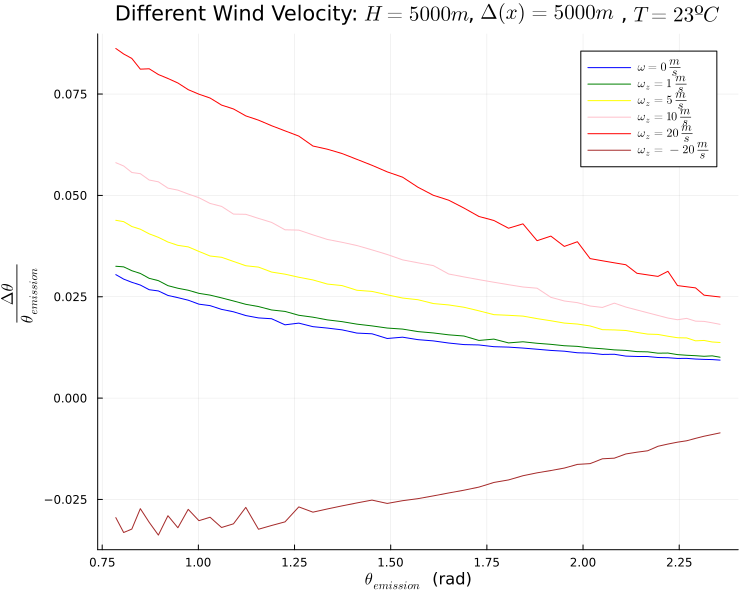

In [7]:
using Plots
y8=(angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000
p = plot(deg2rad.(angulo_recta_5000_5000), y8, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Different Wind Velocity: $H=5000m$, $\Delta (x)=5000m$ , $T=23ºC$",size=(750,600),color=:blue,legend=:topright,
         label=raw"$\omega=0 \frac{m}{s}$")
y9=(angulo_real_5000_5000_1 - angulo_recta_5000_5000_1)./angulo_recta_5000_5000_1
plot!(deg2rad.(angulo_recta_5000_5000_1), y9, color=:green,
         label=raw"$\omega_{z}=1 \frac{m}{s}$")
y10=(angulo_real_5000_5000_5 - angulo_recta_5000_5000_5)./angulo_recta_5000_5000_5
plot!(deg2rad.(angulo_recta_5000_5000_5), y10, color=:yellow,
         label=raw"$\omega_{z}=5 \frac{m}{s}$")
y11=(angulo_real_5000_5000_10 - angulo_recta_5000_5000_10)./angulo_recta_5000_5000_10
plot!(deg2rad.(angulo_recta_5000_5000_10), y11, color=:pink,
         label=raw"$\omega_{z}=10 \frac{m}{s}$")
y12=(angulo_real_5000_5000_20 - angulo_recta_5000_5000_20)./angulo_recta_5000_5000_20
plot!(deg2rad.(angulo_recta_5000_5000_20), y12, color=:red,
         label=raw"$\omega_{z}=20 \frac{m}{s}$")
y13=(angulo_real_5000_5000_l20 - angulo_recta_5000_5000_l20)./angulo_recta_5000_5000_l20
plot!(deg2rad.(angulo_recta_5000_5000_l20), y13, color=:brown,
         label=raw"$\omega_{z}=-20 \frac{m}{s}$")
# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\ComparativaVientos(1.1).png")
p

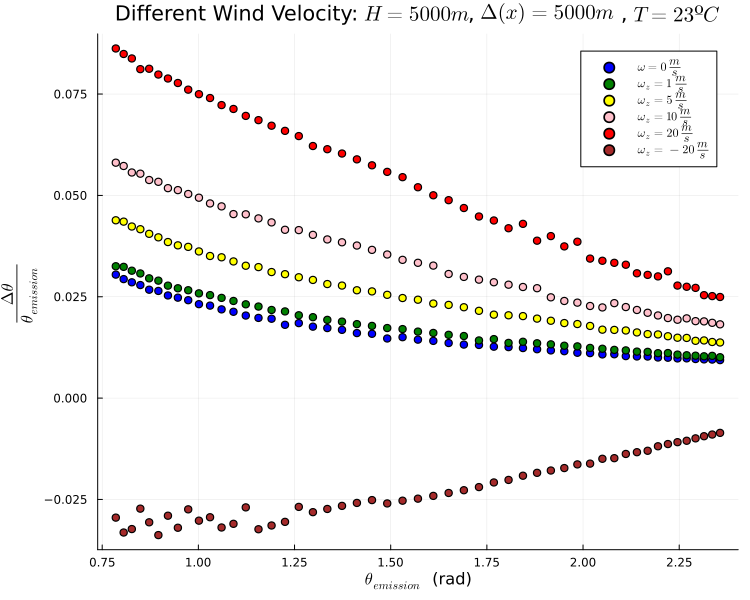

In [8]:
y8=(angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000
p = scatter(deg2rad.(angulo_recta_5000_5000), y8, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Different Wind Velocity: $H=5000m$, $\Delta (x)=5000m$ , $T=23ºC$",size=(750,600),color=:blue,legend=:topright,
         label=raw"$\omega=0 \frac{m}{s}$")
y9=(angulo_real_5000_5000_1 - angulo_recta_5000_5000_1)./angulo_recta_5000_5000_1
scatter!(deg2rad.(angulo_recta_5000_5000_1), y9, color=:green,
         label=raw"$\omega_{z}=1 \frac{m}{s}$")
y10=(angulo_real_5000_5000_5 - angulo_recta_5000_5000_5)./angulo_recta_5000_5000_5
scatter!(deg2rad.(angulo_recta_5000_5000_5), y10, color=:yellow,
         label=raw"$\omega_{z}=5 \frac{m}{s}$")
y11=(angulo_real_5000_5000_10 - angulo_recta_5000_5000_10)./angulo_recta_5000_5000_10
scatter!(deg2rad.(angulo_recta_5000_5000_10), y11, color=:pink,
         label=raw"$\omega_{z}=10 \frac{m}{s}$")
y12=(angulo_real_5000_5000_20 - angulo_recta_5000_5000_20)./angulo_recta_5000_5000_20
scatter!(deg2rad.(angulo_recta_5000_5000_20), y12, color=:red,
         label=raw"$\omega_{z}=20 \frac{m}{s}$")
y13=(angulo_real_5000_5000_l20 - angulo_recta_5000_5000_l20)./angulo_recta_5000_5000_l20
scatter!(deg2rad.(angulo_recta_5000_5000_l20), y13, color=:brown,
         label=raw"$\omega_{z}=-20 \frac{m}{s}$")
# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\ComparativaVientos(1.1)(scatter).png")
p


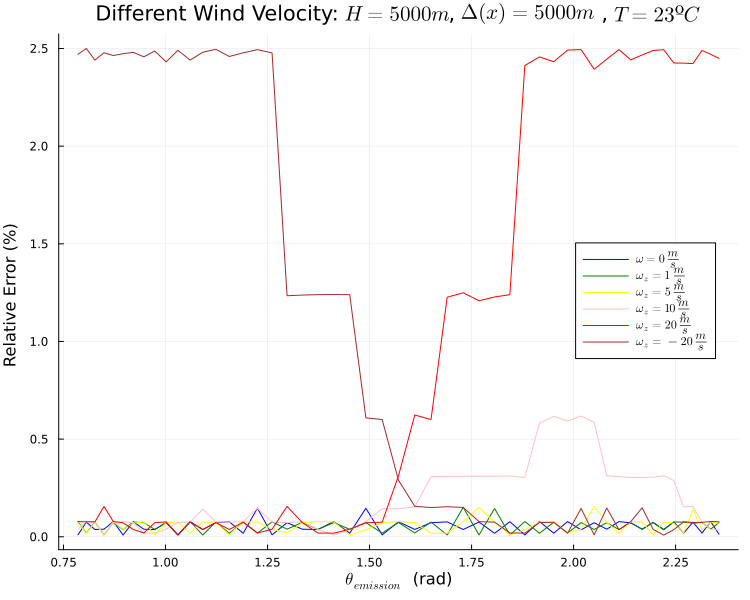

In [9]:
p = plot(deg2rad.(angulo_recta_5000_5000), errores_relativos_5000_5000, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"Relative Error (%) ",
         title=raw"Different Wind Velocity: $H=5000m$, $\Delta (x)=5000m$ , $T=23ºC$",size=(750,600),color=:blue,legend=:right,
         label=raw"$\omega=0 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_1), errores_relativos_5000_5000_1, color=:green,
         label=raw"$\omega_{z}=1 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_5), errores_relativos_5000_5000_5, color=:yellow,
         label=raw"$\omega_{z}=5 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_10), errores_relativos_5000_5000_10, color=:pink,
         label=raw"$\omega_{z}=10 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_20), errores_relativos_5000_5000_20, color=:red,
         label=raw"$\omega_{z}=20 \frac{m}{s}$")

plot!(deg2rad.(angulo_recta_5000_5000_l20), errores_relativos_5000_5000_l20, color=:brown,
         label=raw"$\omega_{z}=-20 \frac{m}{s}$")
# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\Errores_ComparativaVientos(1.1).png")
p 

In [10]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[10.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_X10=[]
angulo_real_5000_5000_X10= []
errores_relativos_5000_5000_X10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_X10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
      if detener==1
            break
        end     
        if v_wind[1:2]==[0.,0.]
                phis=[deepcopy(phi_i)]
                if l==1
                    thetas= range(theta_i, theta_i+10/(2^(l-1)), 50);
                else
                     thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
                end
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
                thetas= range(theta_i, theta_i+10/(2^(l-1)), 50); #Distancia angular de 10 grados como cota superior basado en datos propios
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
                thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_X10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_X10,error_relativo_n)
end
end

Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
Se alcanzó el error relativo objetivo.
660.035095 seconds (9.99 G allocations: 548.387 GiB, 14.91% gc time, 0.01% compilation time: 65% of which was recompilation)


In [11]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[-10.,0.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_Xl10=[]
angulo_real_5000_5000_Xl10= []
errores_relativos_5000_5000_Xl10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_Xl10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        if v_wind[1:2]==[0.,0.]
                phis=[deepcopy(phi_i)]
                if l==1
                    thetas= range(theta_i, theta_i+10/(2^(l-1)), 50);
                else
                     thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
                end
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
                thetas= range(theta_i, theta_i+10/(2^(l-1)), 50); #Distancia angular de 10 grados como cota superior basado en datos propios
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
                thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_Xl10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_Xl10,error_relativo_n)
end
end

220.454442 seconds (3.56 G allocations: 196.373 GiB, 15.21% gc time, 0.04% compilation time: 65% of which was recompilation)


In [12]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,10.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_Y10=[]
angulo_real_5000_5000_Y10= []
errores_relativos_5000_5000_Y10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_Y10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        if v_wind[1:2]==[0.,0.]
                phis=[deepcopy(phi_i)]
                if l==1
                    thetas= range(theta_i, theta_i+10/(2^(l-1)), 50);
                else
                     thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
                end
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
                thetas= range(theta_i, theta_i+10/(2^(l-1)), 50); #Distancia angular de 10 grados como cota superior basado en datos propios
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
                thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_Y10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_Y10,error_relativo_n)
end
end

559.651542 seconds (8.56 G allocations: 470.411 GiB, 14.98% gc time, 0.01% compilation time: 68% of which was recompilation)


In [13]:
using LinearAlgebra
using DifferentialEquations


E_rel=  0.01
T = 23.
v_wind =[0.,-10.,0.]
Source = [0.,0.,5000.]
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
function Slowness_Spherical(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, phi, c_source)
    x1,y1,z1=Point2-Point1 #Obtención parámetros primera iteración
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r))
    q0=1/(c_source + (v_wind[1]*cosd(phi)+ v_wind[2]*sind(phi))*cosd(theta) )
    qx=q0*cosd(phi)*sind(theta)
    qy=q0*sind(phi)*sind(theta)
    qz=q0*cosd(theta)
    return q0,qx,qy,qz,theta
end
function c_z(T,z) 
    if z>0
        c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    else
        c_air=331*sqrt((T+273.15)/273.15)
    end
    return c_air
end
function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
angulo_recta_5000_5000_Yl10=[]
angulo_real_5000_5000_Yl10= []
errores_relativos_5000_5000_Yl10=[]
@time begin
for n in 0:50
    Receiver = [5000.,0.,200*n]
    R=norm(Receiver-Source)
    t_min=R/c_z(T,min(Source[3],Receiver[3]))
    t_max=R/c_z(T, max(Source[3],Receiver[3]))
    phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
    phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
    phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
    #######
    q0,q_x,q_y,q_z,theta_i=Slowness_Spherical(Source,Receiver,v_wind, phi_i, c_source) #Obtención parámetros
    push!(angulo_recta_5000_5000_Yl10,theta_i)
    #######
    traveltime=[]
    detener = 0 # Variable de control
    for l in 1:10
        if detener==1
            break
        end     
        if v_wind[1:2]==[0.,0.]
                phis=[deepcopy(phi_i)]
                if l==1
                    thetas= range(theta_i, theta_i+10/(2^(l-1)), 50);
                else
                     thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
                end
        else
            if l==1
                phis=(min(phi1,phi2):0.05:max(phi1,phi2))
                thetas= range(theta_i, theta_i+10/(2^(l-1)), 50); #Distancia angular de 10 grados como cota superior basado en datos propios
            else
                phi_distance=max(phi1,phi2)-min(phi1,phi2)
                phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
                thetas= range(theta_i-10/(2^(l-1)), theta_i+10/(2^(l-1)), 50);
            end
        end
        angulos_theta = []
        angulos_phi = []
        tiempos = []
        for i in 1:length(thetas)
            for j in 1:length(phis)
                if l>1
                    q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
                end
                q_x=q0*cosd(phis[j])*sind(thetas[i])
                q_y=q0*sind(phis[j])*sind(thetas[i])
                q_z=q0*cosd(thetas[i])
                p = [q_x, q_y]
                u0 = [Source[1],Source[2],Source[3], q_z]
                tspan=[0,t_max]
                prob = ODEProblem(g!, u0, tspan, p)
                paso=1e-2*R/2000
                sol = solve(prob, RK4(), dt=paso, saveat=0:paso:t_max)
                for k in 1:length(sol.u)
                    if detener==0
                        if sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(tiempos, sol.t[k])
                            break
                        elseif sqrt((sol.u[k][1] - Receiver[1])^2 +(sol.u[k][2] - Receiver[2])^2 + (sol.u[k][3] - Receiver[3])^2 ) < R*E_rel/100
                            traveltime = sol.t[k] #Error relativo menor a 0.01% ya detenemos el barrido
                            theta_i = thetas[i]
                            phi_i = phis[j]
                            detener = 1 # Cambiamos el valor de la variable de control
                            println("Se alcanzó el error relativo objetivo.")
                            break
                        end
                    else
                        break
                    end
                end
            end
        end
        if length(tiempos)==0
            if l==1
                println("No se encontró ninguna trayectoria entre fuente y receptor. Valora si estás en una zona de sombra o ajusta el paso de tiempo ")
            end
            break
        elseif detener==0
            traveltime = findmin(tiempos)
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            phi_i=angulos_phi[indice]
        end
    end
    push!(angulo_real_5000_5000_Yl10,theta_i)
    q_x=q0*cosd(phi_i)*sind(theta_i)
    q_y=q0*sind(phi_i)*sind(theta_i)
    q_z=q0*cosd(theta_i)
    # Definir los parámetros
    p = [q_x, q_y]
    u0 = [Source[1],Source[2], Source[3], q_z]
    tspan=[0,traveltime[1]]
    # Crear el problema ODE
    prob = ODEProblem(g!, u0, tspan, p)
    # Resolver el problema ODE
    paso=1e-2*R/2000
    sol = solve(prob, RK4(), dt=paso, saveat=0:paso:traveltime[1])
    error_relativo_n=(sqrt((sol.u[end][1] - Receiver[1])^2 +(sol.u[end][2] - Receiver[2])^2 + (sol.u[end][3] - Receiver[3])^2 )/R)*100
    push!(errores_relativos_5000_5000_Yl10,error_relativo_n)
end
end

568.667172 seconds (8.56 G allocations: 470.445 GiB, 15.04% gc time, 0.01% compilation time: 66% of which was recompilation)


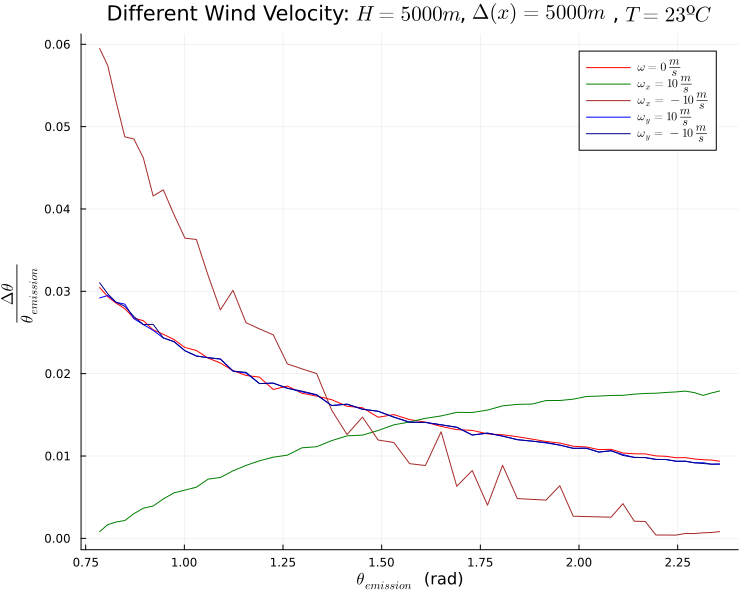

In [14]:
y8=(angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000
p = plot(deg2rad.(angulo_recta_5000_5000), y8, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"$\frac{\Delta \theta}{\theta_{emission}}$ ",
         title=raw"Different Wind Velocity: $H=5000m$, $\Delta (x)=5000m$ , $T=23ºC$",size=(750,600),color=:red,
         label=raw"$\omega=0 \frac{m}{s}$")
y14=(angulo_real_5000_5000_X10 - angulo_recta_5000_5000_X10)./angulo_recta_5000_5000_X10
plot!(deg2rad.(angulo_recta_5000_5000_X10), y14, color=:green,
         label=raw"$\omega_{x}=10 \frac{m}{s}$")
y15=(angulo_real_5000_5000_Xl10 - angulo_recta_5000_5000_Xl10)./angulo_recta_5000_5000_Xl10
plot!(deg2rad.(angulo_recta_5000_5000_Xl10), y15, color=:brown,
         label=raw"$\omega_{x}=-10 \frac{m}{s}$")
y16=(angulo_real_5000_5000_Y10 - angulo_recta_5000_5000_Y10)./angulo_recta_5000_5000_Y10
plot!(deg2rad.(angulo_recta_5000_5000_Y10), y16, color=:blue,
         label=raw"$\omega_{y}=10 \frac{m}{s}$")

y17=(angulo_real_5000_5000_Yl10 - angulo_recta_5000_5000_Yl10)./angulo_recta_5000_5000_Yl10
plot!(deg2rad.(angulo_recta_5000_5000_Yl10), y17, color=:darkblue,
         label=raw"$\omega_{y}=-10 \frac{m}{s}$")


# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\ComparativaVientoXYPositivoNegativo(1.1).png")
p

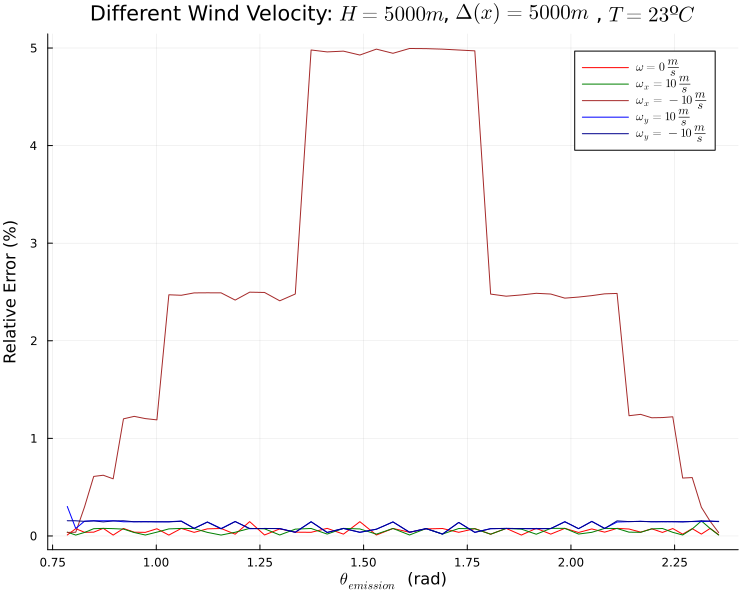

In [15]:
y8=(angulo_real_5000_5000 - angulo_recta_5000_5000)./angulo_recta_5000_5000
p = plot(deg2rad.(angulo_recta_5000_5000), errores_relativos_5000_5000, 
         xlabel=raw"$\theta_{emission}$  (rad)", 
         ylabel=raw"Relative Error (%)",
         title=raw"Different Wind Velocity: $H=5000m$, $\Delta (x)=5000m$ , $T=23ºC$",size=(750,600),color=:red,
         label=raw"$\omega=0 \frac{m}{s}$")
y14=(angulo_real_5000_5000_X10 - angulo_recta_5000_5000_X10)./angulo_recta_5000_5000_X10
plot!(deg2rad.(angulo_recta_5000_5000_X10), errores_relativos_5000_5000_X10, color=:green,
         label=raw"$\omega_{x}=10 \frac{m}{s}$")
y15=(angulo_real_5000_5000_Xl10 - angulo_recta_5000_5000_Xl10)./angulo_recta_5000_5000_Xl10
plot!(deg2rad.(angulo_recta_5000_5000_Xl10), errores_relativos_5000_5000_Xl10, color=:brown,
         label=raw"$\omega_{x}=-10 \frac{m}{s}$")
y16=(angulo_real_5000_5000_Y10 - angulo_recta_5000_5000_Y10)./angulo_recta_5000_5000_Y10
plot!(deg2rad.(angulo_recta_5000_5000_Y10), errores_relativos_5000_5000_Y10, color=:blue,
         label=raw"$\omega_{y}=10 \frac{m}{s}$")

y17=(angulo_real_5000_5000_Yl10 - angulo_recta_5000_5000_Yl10)./angulo_recta_5000_5000_Yl10
plot!(deg2rad.(angulo_recta_5000_5000_Yl10), errores_relativos_5000_5000_Yl10, color=:darkblue,
         label=raw"$\omega_{y}=-10 \frac{m}{s}$")


# Guardar la gráfica en un archivo
savefig(p, "C:\\Users\\Miguel\\Desktop\\TFM\\Ángulos_Probables_Theta\\Errores_ComparativaVientoXYPositivoNegativo(1.1).png")
p